# The Metabolic Index

The Metabolic Index {cite}`Deutsch-Ferrel-etal-2015` is defined as the ratio of oxygen supply to the oxygen demand necessary to sustain respiratory metabolism. Ignoring dependence on body size (mass), the Metabolic Index ($\Phi$) is defined as follows.


$$
  \Phi = A_o \frac{P_{\mathrm{O}_2}}
  {\mathrm{exp}\left[
  \frac{-E_o}{k_B}\left(
  \frac{1}{T} - \frac{1}{T_{ref}}
  \right)
  \right]
  }
$$

Oxygen supply depends on the availability of oxygen in the environment, quantified by the partial pressure of oxygen ($P_{\mathrm{O}_2}$), as well as the physiological acquisition and transport capacities of organisms. The aggegration of these capacities yields a "hypoxic tolerance" trait that varies across marine organisms and is represented by the parameter $A_o$.

Oxygen demand scales as a function of temperature-dependent metabolic rate, represented by the [Arrhenius Equation](https://en.wikipedia.org/wiki/Arrhenius_equation). The temperature sensitivity of metabolic rate is specified by the parameter $E_o$, which is a trait that varies across species.


Where the $\Phi >= 1$, an organism can meet its resting metabolic demand. Notably, however, this precludes activity necessary for reproduction and feeding; thus organisms require $\Phi >= \Phi_{crit}$, where $\Phi_{crit}$ is the minimum value of $\Phi$ sufficient to sustain ecologically-relevant metabolic rates. 

Here we provide a illustration of how $\Phi$ enables quanitification of habitability in the context of constraints imposed by the requirements of aerobic metabolism.

In [2]:
%load_ext autoreload
%autoreload 2

import cmocean
import constants
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import util
import xarray as xr
from scipy import stats as scistats

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Load traits database

Load a subset of the trait data from {cite:t}`Deutsch-Penn-etal-2020`, including only the marine organisms for which temerature-dependent hypoxia metabolic traits have been determined. 

The `open_traits_df` function is defined in the [metabolic](https://github.com/matt-long/aerobic-safety-margins/blob/main/notebooks/metabolic.py) module and  makes the trait data available via a [pandas](https://pandas.pydata.org/) `DataFrame`.

In [3]:
df = mi.open_traits_df()
df

,Species,Phylum,alphaD_log10,Emet,Eo,Ao,Ac,Phi_crit
0,Acanthephyra acutifrons,Crustacea,0.479565,0.040200,-0.027836,0.264715,0.131959,2.006040
1,Acanthephyra curtirostris,Crustacea,0.377714,0.043938,0.038027,0.252578,0.141861,1.780456
2,Acanthephyra purpurea,Crustacea,1.035748,0.840722,0.131972,0.230068,0.073638,3.124330
3,Acanthephyra smithi,Crustacea,1.082577,0.313173,-0.030067,0.286307,0.174423,1.641453
4,Acipenser brevirostrum,Chordata,NaN,NaN,0.362569,0.218524,0.048415,4.513525
...,...,...,...,...,...,...,...,...
56,Styela plicata,Tunicata,0.433791,0.346635,-0.190998,0.061336,0.043505,1.409863
57,Systellaspis debilis,Crustacea,0.779626,0.418652,0.226970,0.219289,0.096003,2.284196
58,Tarletonbeania crenularis,Chordata,NaN,NaN,0.213307,0.203696,0.051780,3.933876
59,Tautogolabrus adspersus,Chordata,0.801974,0.327012,0.244520,0.170886,0.051204,3.337395


Pull out some median traits for illustration purposes. [This notebook](./trait-space-joint-pdf.ipynb) presents a full exploration of trait PDFs. 

In [11]:
Ac_med = mi.trait_pdf(df, 'Ac', 30).median()
print(f'Median Ac = {Ac_med:0.3f} 1/kPa')

0.078 1/kPa


In [12]:
Ao_med = mi.trait_pdf(df, 'Ao', 30).median()
print(f'Median Ao = {Ao_med:0.3f} 1/kPa')

0.217 1/kPa


In [13]:
Eo_med = mi.trait_pdf(df, 'Eo', 30).median()
print(f'Median Eo = {Eo_med:0.3f} eV')

0.381 eV


## Explaining the Metabolic Index

In the cell below, we define a function that plots curves of constant $\Phi$ in in \PO2{}-temperature space (click "+" at right to see the code).

In [5]:
def plot_MI_illustration(which):
    fig, ax = plt.subplots()

    PO2_atm = constants.XiO2 * constants.kPa_per_atm
    T = np.arange(0, 32, 0.1)

    pO2_at_Phi_crit = mi.pO2_at_Phi_one(T, Ac_med, Eo_med * 2)
    pO2_at_Phi_one = mi.pO2_at_Phi_one(T, Ao_med, Eo_med * 2)

    ATmax_crit = mi.compute_ATmax(PO2_atm, Ac_med, Eo_med * 2)
    ATmax_one = mi.compute_ATmax(PO2_atm, Ao_med, Eo_med * 2)

    color_rest = 'tab:blue'
    color_active = 'tab:red'

    # active
    if 'active' in which:
        ax.plot(T, pO2_at_Phi_crit, '-', linewidth=2, color=color_active)
        ax.fill_between(
            T,
            pO2_at_Phi_crit,
            constants.XiO2 * constants.kPa_per_atm,
            where=pO2_at_Phi_crit <= PO2_atm,
            color='tab:green',
            alpha=0.5,
        )
        ax.plot(
            ATmax_crit,
            PO2_atm,
            'o',
            color=color_active,
        )
        ax.text(
            10,
            mi.pO2_at_Phi_one(10, Ac_med, Eo_med * 2) - 1.5,
            r'$\Phi = \Phi_{crit}$',
            color=color_active,
            fontsize=16,
            rotation=35,
        )

    # resting
    ax.plot(T, pO2_at_Phi_one, '-', linewidth=2, color=color_rest)
    ax.plot(
        ATmax_one,
        PO2_atm,
        'o',
        color=color_rest,
    )
    ax.text(
        25,
        mi.pO2_at_Phi_one(25, Ao_med, Eo_med * 2) - 1.5,
        r'$\Phi = 1$',
        color=color_rest,
        fontsize=16,
        rotation=48,
    )

    if 'resting' in which:
        ax.fill_between(
            T,
            pO2_at_Phi_one,
            constants.XiO2 * constants.kPa_per_atm,
            where=pO2_at_Phi_one <= PO2_atm,
            color='tab:green',
            alpha=0.5,
        )

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([T.min(), T.max()])
    ax.set_xlabel('Temperature [°C]')
    ax.set_ylabel(r'$P_{\mathrm{O}_2}$ [kPa]')

    xlm = ax.get_xlim()
    ylm = (-2.6251270379913803, 73.89798889088694)  # ax.get_ylim()

    ax.set_ylim([ylm[0], PO2_atm + 0.05 * np.diff(ylm)])

    ax.axhline(PO2_atm, linewidth=1, color='k', linestyle='--', zorder=-100)
    ax.text(
        xlm[0] + 0.05 * np.diff(xlm), PO2_atm + 0.01 * np.diff(ylm), r'$P_{\mathrm{O}_2}^{atm}$'
    )

    if 'base' in which:
        ax.plot(
            [15.0, 15.0],
            [ylm[0], mi.pO2_at_Phi_one(15, Ao_med, Eo_med * 2)],
            '--',
            color=color_rest,
        )
        ax.plot(
            [xlm[0], 15.0],
            [mi.pO2_at_Phi_one(15, Ao_med, Eo_med * 2), mi.pO2_at_Phi_one(15, Ao_med, Eo_med * 2)],
            '--',
            color=color_rest,
        )
        ax.text(15 - 0.25, ylm[0] + 0.01 * np.diff(ylm), 'T$_{ref}$', ha='right', color=color_rest)

        ax.text(
            15 / 2,
            mi.pO2_at_Phi_one(15, Ao_med, Eo_med * 2) + 0.01 * np.diff(ylm),
            '$1/A_o$ = Hypoxic tolerance',
            ha='center',
            color=color_rest,
        )

        spc = ' ' * 23
        ax.text(
            18,
            mi.pO2_at_Phi_one(18, Ao_med, Eo_med * 2) - 0.06 * np.diff(ylm),
            f'slope $\\propto$ $E_o$ = Temperature\n{spc}sensitivity of\n{spc}metabolism',
            ha='left',
            color=color_rest,
        )

    if 'resting' in which:
        ax.text(7, PO2_atm / 1.5, 'Habitable', color='tab:green', fontsize=16, fontweight='bold')
        ax.text(18, PO2_atm / 12, 'Not\nhabitable', color='tab:red', fontsize=16, fontweight='bold')

    if 'resting' in which or 'active' in which:
        ax.plot([ATmax_one, ATmax_one], [ylm[0], PO2_atm], '--', color=color_rest)
        ax.text(
            ATmax_one - 0.25,
            ylm[0] + 0.01 * np.diff(ylm),
            'Resting\nAT$_{max}$',
            ha='right',
            color=color_rest,
        )

    if 'active' in which:
        ax.plot([ATmax_crit, ATmax_crit], [ylm[0], PO2_atm], '--', color=color_active)
        ax.text(
            ATmax_crit - 0.25,
            ylm[0] + 0.01 * np.diff(ylm),
            'Active\nAT$_{max}$',
            ha='right',
            color=color_active,
        )

    plt.savefig(f'figures/misc/phi-explain-{which}.png', dpi=300)

Using this function, we can produce a figure similar to Fig 1 of {cite:t}`Deutsch-Penn-etal-2020`, showing curves of constant $\Phi$ in $P_{\mathrm{O}_2}$-temperature space. 

This plot illustrates how the paramters control the shape of the curve.

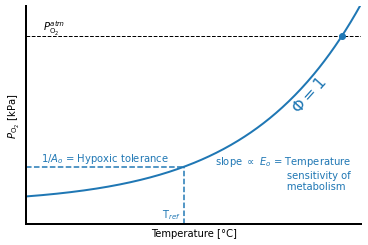

In [6]:
plot_MI_illustration('base')

The $\Phi = 1$ line delineates the region in $P_{\mathrm{O}_2}$-temperature space that is habitable from that that is too warm with insufficient oxygen. The intersection of this line with $P_{\mathrm{O}_2}^{atm}$ defines the maximum temperature at which metabolism can be sustained.

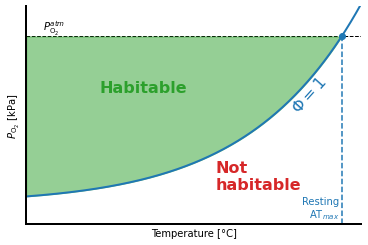

In [7]:
plot_MI_illustration('resting')

Ecological requirements to sustain metabolic rates above those of resting metabolism impose further restrictions on habiability.

The $\Phi = \Phi_{crit}$ line inscribes a smaller region of habitability in $P_{\mathrm{O}_2}$-temperature space than that corresponding to resting metabolism ($\Phi = 1$).

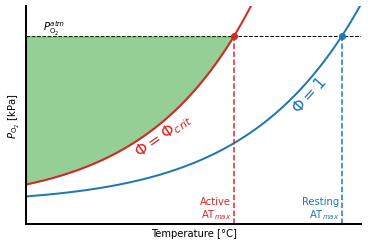

In [8]:
plot_MI_illustration('active')